In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from output_utils import plot_heatmap_on_map
import numpy as np
import hopsworks
import os

# Authenticate into Earth Engine

In [ ]:
import ee, json, os

# Check if running in GitHub Actions or locally
if 'EE_SERVICE_ACCOUNT_KEY' in os.environ:
    key = json.loads(os.environ['EE_SERVICE_ACCOUNT_KEY'])
    credentials = ee.ServiceAccountCredentials(
        key["client_email"],
        key_data=json.dumps(key)
    )
    ee.Initialize(credentials=credentials)
else:

    with open("../ee.json") as f:
        key = json.load(f)

    credentials = ee.ServiceAccountCredentials(
        key["client_email"],
        key_data=json.dumps(key)
    )

    ee.Initialize(credentials)


from download_utils import download_monthly_ndvi, era5_grid_to_points_df

# Overview
This notebook is run every 16 days. NDVI data is downloaded over 16 day periods.

# Download NDVI data

In [47]:
save = False


In [48]:
end = pd.Timestamp.today().normalize() - pd.Timedelta(days=7)
start = end.replace(day=1) - relativedelta(months=2)

months = [
    (end - pd.DateOffset(months=i)).replace(day=1).normalize()
    for i in range(3)
]
months

[Timestamp('2025-12-01 00:00:00'),
 Timestamp('2025-11-01 00:00:00'),
 Timestamp('2025-10-01 00:00:00')]

### Prepare dataframe of points to sample NDVI values from

In [49]:
# months_df = pd.DataFrame({"Month": pd.to_datetime(months)})
# months_df["Month"] = pd.to_datetime(months_df["Month"].dt.date)
# months_df["key"] = 1

era5_points_df = pd.read_csv('../data/country/era5coords_df.csv')
print(f"Era5Land Sweden has {len(era5_points_df)} coordinates")
# era5_points_df["key"] = 1
# era5_points_df = era5_points_df.merge(months_df, on="key").drop(columns="key")
era5_points_df

Era5Land Sweden has 7956 coordinates


,row_id,Lat,Lon
0,0,69.1,20.6
1,1,69.0,20.1
2,2,69.0,20.2
3,3,69.0,20.3
4,4,69.0,20.4
...,...,...,...
7951,7951,55.4,13.5
7952,7952,55.4,13.6
7953,7953,55.4,13.7
7954,7954,55.4,13.8


In [50]:
# from shapely.geometry import Point

# era5_gdf = geopandas.GeoDataFrame(
#     era5_points_df,
#     geometry=geopandas.points_from_xy(era5_points_df["Lon"], era5_points_df["Lat"]),
#     crs="EPSG:4326"
# )

# url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

# world = geopandas.read_file(url)
# sweden = world[world["NAME"] == "Sweden"].to_crs("EPSG:4326")

# era5_sweden = geopandas.sjoin(
#     era5_gdf,
#     sweden[["geometry"]],
#     how="inner",
#     predicate="within"
# ).drop(columns="index_right")

# era5_sweden_df = era5_sweden.drop(columns="geometry")

# era5_sweden_df.to_csv('../data/country/era5coords_df.csv', index=False)

In [51]:
modis = ee.ImageCollection("MODIS/061/MOD13Q1").select("NDVI")

ndvi_df = download_monthly_ndvi(
    dataset=modis,
    points_df=era5_points_df,
    months=months,
    chunk_size=4000
)

ndvi_df = ndvi_df.sort_values(["row_id", "Month"])
ndvi_df

Months: 100%|██████████| 3/3 [00:46<00:00, 15.50s/it]


,row_id,Month,NDVI,Lat,Lon
23664,0,2025-10-01,NaN,69.1,20.6
7956,0,2025-11-01,-0.0289,69.1,20.6
3347,0,2025-12-01,NaN,69.1,20.6
15912,1,2025-10-01,-0.0636,69.0,20.1
7957,1,2025-11-01,-0.0478,69.0,20.1
...,...,...,...,...,...
15910,7954,2025-11-01,NaN,55.4,13.8
7954,7954,2025-12-01,NaN,55.4,13.8
23867,7955,2025-10-01,NaN,55.4,13.9
15911,7955,2025-11-01,NaN,55.4,13.9


### Replace missing NDVI with average from nearby

In [52]:
coord_to_row = {}
for _, row in era5_points_df.iterrows():
    coord_to_row[(row["Lat"], row["Lon"])] = int(row["row_id"])

# Get unique lat/lon values and their step sizes to find neighbors
unique_lats = sorted(era5_points_df["Lat"].unique())
unique_lons = sorted(era5_points_df["Lon"].unique())

lat_step, lon_step = 0.1, 0.1 # ERA5 Land res

# For each None value, find neighboring row_ids and average their NDVI
ndvi_filled = ndvi_df.copy()
ndvi_original = ndvi_df.copy()  # Keep original to avoid modifying while reading

nan_count_before = ndvi_filled["NDVI"].isna().sum()
print(f"NaN count before: {nan_count_before}")

pass1_count = 0
pass2_count = 0
pass3_count = 0

for idx, row in ndvi_filled.iterrows():
    if pd.isna(row["NDVI"]):
        lat = row["Lat"]
        lon = row["Lon"]
        month = row["Month"]
        row_id = row["row_id"]
        
        # Define all 9 cells (3x3 grid, including center)
        neighbor_lats = [lat - lat_step, lat, lat + lat_step]
        neighbor_lons = [lon - lon_step, lon, lon + lon_step]
        
        # Pass 1: Fill using neighboring coordinates (3x3 grid) in the same month
        neighbor_ndvi_values = []
        for n_lat in neighbor_lats:
            for n_lon in neighbor_lons:
                if (n_lat, n_lon) in coord_to_row:
                    neighbor_row_id = coord_to_row[(n_lat, n_lon)]
                    neighbor_ndvi = ndvi_original[
                        (ndvi_original["row_id"] == neighbor_row_id) & 
                        (ndvi_original["Month"] == month)
                    ]["NDVI"].values
                    if len(neighbor_ndvi) > 0 and not pd.isna(neighbor_ndvi[0]):
                        neighbor_ndvi_values.append(neighbor_ndvi[0])
        
        if neighbor_ndvi_values:
            ndvi_filled.at[idx, "NDVI"] = np.mean(neighbor_ndvi_values)
            pass1_count += 1
        else:
            # Pass 2: Fill with temporal average from same location (all months)
            location_values = ndvi_original[
                (ndvi_original["row_id"] == row_id) & 
                (~ndvi_original["NDVI"].isna())
            ]["NDVI"].values
            
            if len(location_values) > 0:
                ndvi_filled.at[idx, "NDVI"] = np.mean(location_values)
                pass2_count += 1
            # else:
            #     # Pass 3: Fill with spatial neighbors (any month)
            #     neighbor_ndvi_values = []
            #     for n_lat in neighbor_lats:
            #         for n_lon in neighbor_lons:
            #             if (n_lat, n_lon) in coord_to_row:
            #                 neighbor_row_id = coord_to_row[(n_lat, n_lon)]
            #                 neighbor_ndvi = ndvi_original[
            #                     (ndvi_original["row_id"] == neighbor_row_id) & 
            #                     (~ndvi_original["NDVI"].isna())
            #                 ]["NDVI"].values
            #                 if len(neighbor_ndvi) > 0:
            #                     neighbor_ndvi_values.extend(neighbor_ndvi)
                
            #     if neighbor_ndvi_values:
            #         ndvi_filled.at[idx, "NDVI"] = np.mean(neighbor_ndvi_values)
            #         pass3_count += 1

nan_count_after = ndvi_filled["NDVI"].isna().sum()
print(f"\nPass 1 (spatial same month): {pass1_count} filled")
print(f"Pass 2 (temporal same location): {pass2_count} filled")
print(f"Pass 3 (spatial + temporal): {pass3_count} filled")
print(f"\nNaN count after: {nan_count_after}")
print(f"Total NaNs filled: {nan_count_before - nan_count_after}")

ndvi_filled

NaN count before: 5184

Pass 1 (spatial same month): 757 filled
Pass 2 (temporal same location): 4322 filled
Pass 3 (spatial + temporal): 0 filled

NaN count after: 105
Total NaNs filled: 5079


,row_id,Month,NDVI,Lat,Lon
23664,0,2025-10-01,0.007150,69.1,20.6
7956,0,2025-11-01,-0.028900,69.1,20.6
3347,0,2025-12-01,-0.028900,69.1,20.6
15912,1,2025-10-01,-0.063600,69.0,20.1
7957,1,2025-11-01,-0.047800,69.0,20.1
...,...,...,...,...,...
15910,7954,2025-11-01,0.584850,55.4,13.8
7954,7954,2025-12-01,0.167050,55.4,13.8
23867,7955,2025-10-01,0.625733,55.4,13.9
15911,7955,2025-11-01,0.647133,55.4,13.9


In [53]:
ndvi_features = ndvi_filled.dropna().copy()
ndvi_features = ndvi_features.sort_values(["Lat", "Lon", "Month"])


MAX_LAG = 2

for lag in range(1, MAX_LAG + 1):
    ndvi_features[f"NDVI_lag{lag}"] = (
        ndvi_features
        .groupby(["Lat", "Lon"])["NDVI"]
        .shift(lag)
    )

ndvi_features.dropna(inplace=True)
l2 = len(ndvi_features)
print(f"NDVI points: {l2} ({int(l2/len(era5_points_df)*100)}%)")
ndvi_features.columns = [c.lower() for c in ndvi_features.columns]
ndvi_features

NDVI points: 7899 (99%)


,row_id,month,ndvi,lat,lon,ndvi_lag1,ndvi_lag2
3340,7946,2025-12-01,0.1894,55.4,13.0,0.64085,0.48360
3341,7947,2025-12-01,0.1338,55.4,13.1,0.41430,0.34290
3342,7948,2025-12-01,0.2322,55.4,13.2,0.66615,0.66430
3343,7949,2025-12-01,0.1632,55.4,13.3,0.30240,0.75260
3344,7950,2025-12-01,0.1533,55.4,13.4,0.51835,0.74040
...,...,...,...,...,...,...,...
3353,6,2025-12-01,-0.0668,69.0,20.6,-0.16910,0.03550
3354,7,2025-12-01,-0.0857,69.0,20.7,-0.10690,-0.06450
3355,8,2025-12-01,-0.0666,69.0,20.8,-0.16070,0.02750
3356,9,2025-12-01,0.0692,69.0,20.9,0.04060,0.09780


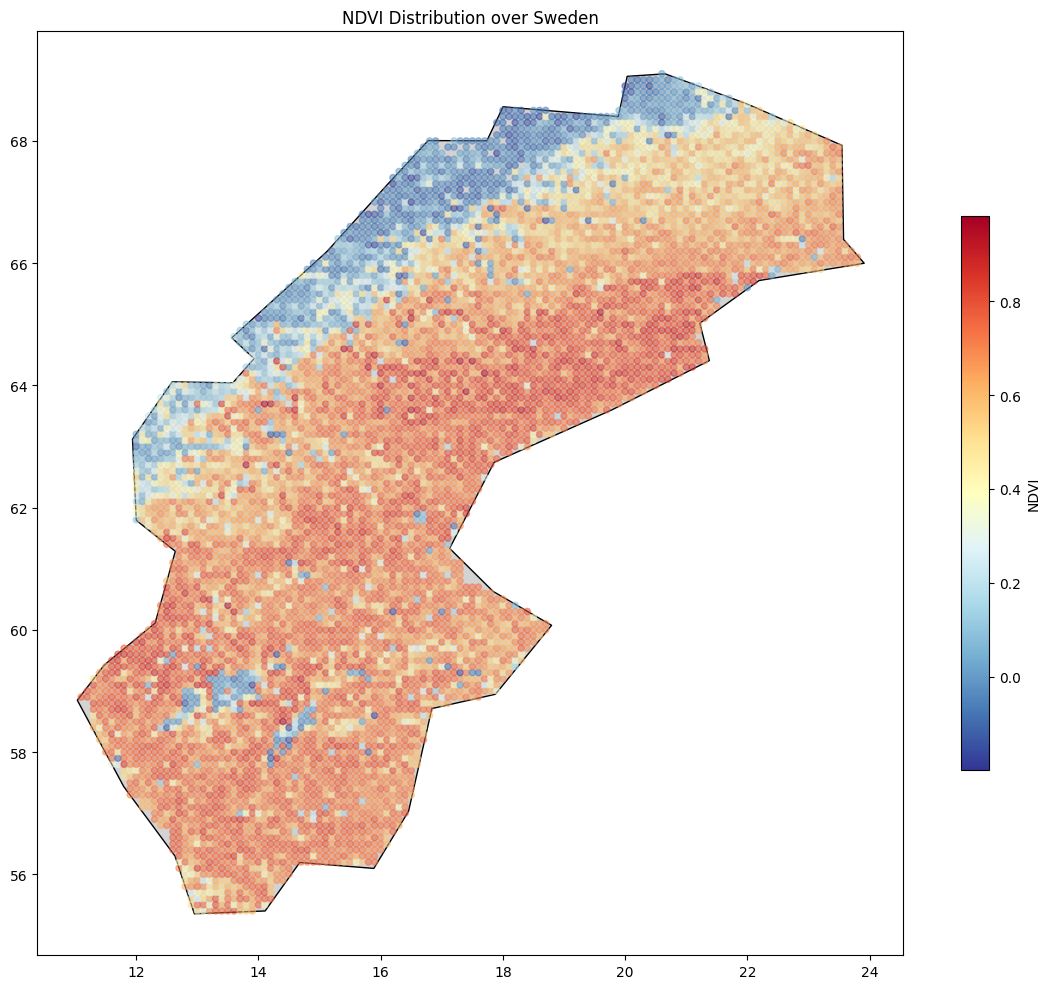

In [ ]:
# Only plot if running locally (not in CI/CD)
if 'GITHUB_ACTIONS' not in os.environ:
    plot_heatmap_on_map(ndvi_features, 'ndvi_lag2', 'NDVI')
else:
    print("Skipping plot generation in CI/CD")

In [55]:
if save: ndvi_features.to_csv('../data/ndvi/ndvi_' + str(end.day) + '_' + str(end.month) + '_' + str(end.year) + '_.csv', index=False)

# Add to Hopsworks

In [ ]:

# Only load from file if it exists (when running locally with save=True)
csv_path = '../data/ndvi/ndvi_29_12_2025_.csv'
if os.path.exists(csv_path):
    ndvi_features = pd.read_csv(csv_path)
    ndvi_features['month'] = pd.to_datetime(ndvi_features['month']).dt.tz_localize(None)
    print(f"Loaded NDVI features from {csv_path}")
else:
    print("Using ndvi_features from memory (file not saved)")

ndvi_features

,month,lat,lon,ndvi_lag1,ndvi_lag2
0,2025-12-01,55.4,13.0,0.64085,0.48360
1,2025-12-01,55.4,13.1,0.41430,0.34290
2,2025-12-01,55.4,13.2,0.66615,0.66430
3,2025-12-01,55.4,13.3,0.30240,0.75260
4,2025-12-01,55.4,13.4,0.51835,0.74040
...,...,...,...,...,...
7894,2025-12-01,69.0,20.6,-0.16910,0.03550
7895,2025-12-01,69.0,20.7,-0.10690,-0.06450
7896,2025-12-01,69.0,20.8,-0.16070,0.02750
7897,2025-12-01,69.0,20.9,0.04060,0.09780


In [57]:
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-06 05:35:51,746 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-06 05:35:51,749 INFO: Initializing external client
2026-01-06 05:35:51,749 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-06 05:35:53,213 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351


In [ ]:
# Retrieve feature groups
ndvi_fg = fs.get_or_create_feature_group(
    name='ndvi',
    version=2,
)

ndvi_fg.insert(ndvi_features)

Uploading Dataframe: 100.00% |██████████| Rows 7899/7899 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: ndvi_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286351/jobs/named/ndvi_2_offline_fg_materialization/executions


(Job('ndvi_2_offline_fg_materialization', 'SPARK'), None)